使用的设备: cuda
>>> 1. 加载图数据...
数据加载成功！
Data(x=[46564, 165], edge_index=[2, 36624], y=[46564], train_mask=[46564], test_mask=[46564])
特征数: 165, 类别数: 2
训练集节点数: 29894
测试集节点数: 16670


C:\Users\zhj\AppData\Local\Temp\ipykernel_35996\1899279221.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('../data/processed/elliptic_pyg.pt')



>>> 类别不平衡处理: 正样本权重 (pos_weight) 设置为: 7.63

>>> [Model 1] 训练 GCN...
开始训练 GCN (200 epochs)...
Epoch 020 | Loss: 0.2816 | Train Illicit F1: 0.6305
Epoch 040 | Loss: 0.2303 | Train Illicit F1: 0.6716
Epoch 060 | Loss: 0.2015 | Train Illicit F1: 0.7076
Epoch 080 | Loss: 0.1779 | Train Illicit F1: 0.7353
Epoch 100 | Loss: 0.1647 | Train Illicit F1: 0.7589
Epoch 120 | Loss: 0.1542 | Train Illicit F1: 0.7725
Epoch 140 | Loss: 0.1439 | Train Illicit F1: 0.7864
Epoch 160 | Loss: 0.1416 | Train Illicit F1: 0.7909
Epoch 180 | Loss: 0.1343 | Train Illicit F1: 0.7888
Epoch 200 | Loss: 0.1329 | Train Illicit F1: 0.7944

==================== GCN 测试集评估 ====================
              precision    recall  f1-score   support

       Licit       0.97      0.96      0.97     15587
     Illicit       0.52      0.62      0.57      1083

    accuracy                           0.94     16670
   macro avg       0.75      0.79      0.77     16670
weighted avg       0.94      0.94      0.94     16670

🔴 Illic

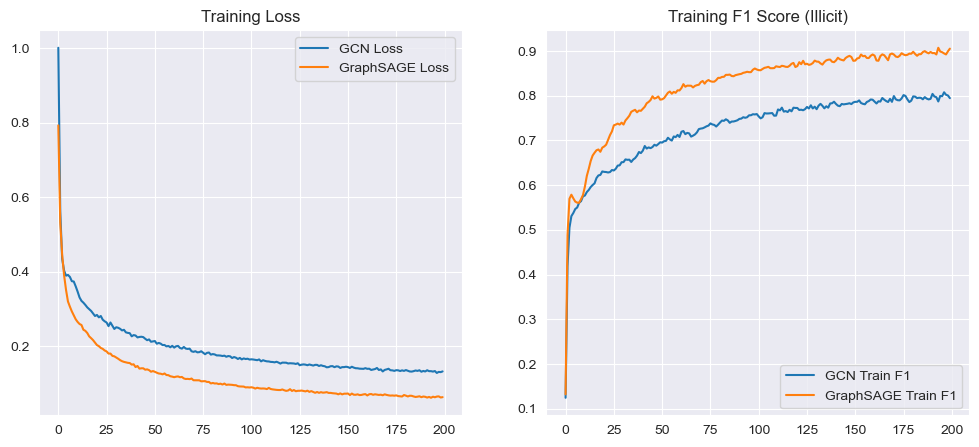


>>> GNN 模型最终对比 <<<
                 F1    Recall  Precision
Model                                   
GCN        0.565144  0.616805   0.521468
GraphSAGE  0.609696  0.685134   0.549223


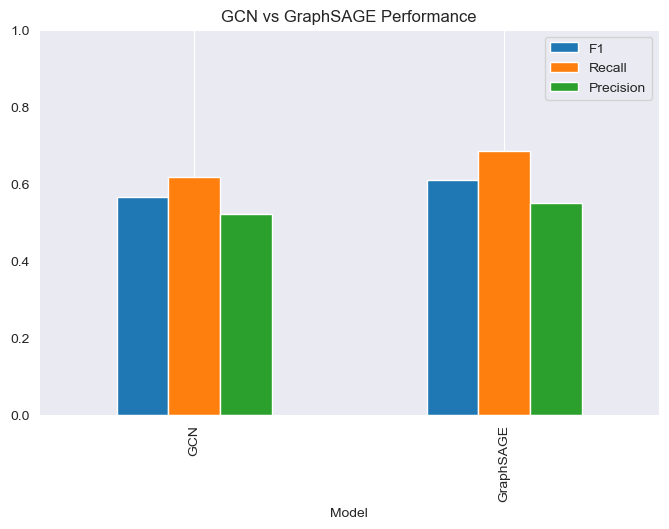

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 设置设备 (优先使用 GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# ==========================================
# 1. 加载 PyG 数据对象
# ==========================================
print(">>> 1. 加载图数据...")
try:
    data = torch.load('../data/processed/elliptic_pyg.pt')
    data = data.to(device) # 将数据移动到 GPU/CPU
    print("数据加载成功！")
    print(data)
    print(f"特征数: {data.num_features}, 类别数: 2")
    print(f"训练集节点数: {data.train_mask.sum().item()}")
    print(f"测试集节点数: {data.test_mask.sum().item()}")
except FileNotFoundError:
    print("❌ 错误：找不到 '../data/processed/elliptic_pyg.pt'。请先运行 02_data_processing.ipynb。")

# ==========================================
# 2. 定义 GNN 模型 (GCN & GraphSAGE)
# ==========================================

# --- 模型 A: GCN (Graph Convolutional Network) ---
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # 第一层卷积
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # 第二层卷积
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) # Dropout 防止过拟合

        # Layer 2
        x = self.conv2(x, edge_index)
        return x

# --- 模型 B: GraphSAGE (Sample and Aggregate) ---
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        # aggr='mean': 聚合邻居特征的平均值
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        return x

# ==========================================
# 3. 训练与评估辅助函数
# ==========================================

# 计算类别权重 (处理不平衡)
# Weight = (Total Neg) / (Total Pos)
num_neg = (data.y[data.train_mask] == 0).sum().item()
num_pos = (data.y[data.train_mask] == 1).sum().item()
pos_weight = torch.tensor([num_neg / num_pos]).to(device)
print(f"\n>>> 类别不平衡处理: 正样本权重 (pos_weight) 设置为: {pos_weight.item():.2f}")

def train_model(model, data, epochs=200, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    # 使用 BCEWithLogitsLoss (自带 Sigmoid) 适合二分类，且支持 pos_weight
    # 注意：BCE 需要输出是一维的，所以我们取第2个维度的输出或者改模型输出为1维
    # 这里为了方便，还是用 CrossEntropyLoss 并传入 weight 参数

    # 重新定义权重供 CrossEntropy 使用: [weight_class_0, weight_class_1]
    class_weights = torch.tensor([1.0, pos_weight.item()]).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    history = {'loss': [], 'f1': []}

    model.train()
    print(f"开始训练 {model.__class__.__name__} ({epochs} epochs)...")

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # 只计算训练集节点的 Loss
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # 简单记录一下 F1 (仅供观察进度)
        pred = out.argmax(dim=1)
        # 转换为 CPU 计算 sklearn 指标
        train_f1 = f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu(), average='binary', pos_label=1)

        history['loss'].append(loss.item())
        history['f1'].append(train_f1)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Train Illicit F1: {train_f1:.4f}')

    return history

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # 只评估测试集
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        print(f"\n{'='*20} {model.__class__.__name__} 测试集评估 {'='*20}")
        print(classification_report(y_true, y_pred, target_names=['Licit', 'Illicit']))

        f1 = f1_score(y_true, y_pred, pos_label=1)
        rec = recall_score(y_true, y_pred, pos_label=1)
        prec = precision_score(y_true, y_pred, pos_label=1)

        print(f"🔴 Illicit F1-Score: {f1:.4f}")
        print(f"🔴 Recall:          {rec:.4f}")
        print(f"🔴 Precision:       {prec:.4f}")

        return {'F1': f1, 'Recall': rec, 'Precision': prec}

# ==========================================
# 4. 运行实验
# ==========================================

# --- 实验 1: GCN ---
print("\n>>> [Model 1] 训练 GCN...")
gcn_model = GCN(in_channels=data.num_features, hidden_channels=128, out_channels=2).to(device)
gcn_history = train_model(gcn_model, data, epochs=200, learning_rate=0.005)
gcn_metrics = evaluate_model(gcn_model, data)

# --- 实验 2: GraphSAGE ---
print("\n>>> [Model 2] 训练 GraphSAGE...")
sage_model = GraphSAGE(in_channels=data.num_features, hidden_channels=128, out_channels=2).to(device)
sage_history = train_model(sage_model, data, epochs=200, learning_rate=0.005)
sage_metrics = evaluate_model(sage_model, data)

# ==========================================
# 5. 结果对比与可视化
# ==========================================
# 训练曲线对比
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(gcn_history['loss'], label='GCN Loss')
plt.plot(sage_history['loss'], label='GraphSAGE Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gcn_history['f1'], label='GCN Train F1')
plt.plot(sage_history['f1'], label='GraphSAGE Train F1')
plt.title('Training F1 Score (Illicit)')
plt.legend()
plt.show()

# 最终指标对比
results = pd.DataFrame([
    {'Model': 'GCN', **gcn_metrics},
    {'Model': 'GraphSAGE', **sage_metrics}
]).set_index('Model')

print("\n>>> GNN 模型最终对比 <<<")
print(results)

results.plot(kind='bar', figsize=(8, 5))
plt.title('GCN vs GraphSAGE Performance')
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.show()